# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

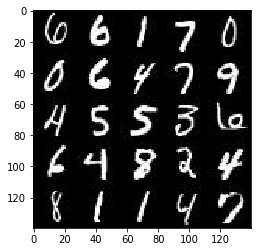

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

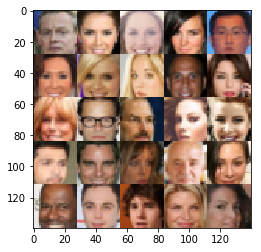

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
tf.reset_default_graph()

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_inputs')
    z_data = tf.placeholder(tf.float32, shape=[None, z_dim], name='z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_input, z_data, learning_rate 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        d_conv0 = tf.layers.conv2d(images, filters=64, kernel_size=5,strides=2, padding='same')
        d_batch_norm0 = tf.layers.batch_normalization(d_conv0,training=True)
        d_leaky_relu0 = tf.maximum(d_batch_norm0*0.2, d_batch_norm0)
        
        d_conv1 = tf.layers.conv2d(d_leaky_relu0, filters=128, kernel_size=5,strides=2, padding='same')
        d_batch_norm1 = tf.layers.batch_normalization(d_conv1,training=True)
        d_leaky_relu1 = tf.maximum(d_batch_norm1*0.2, d_batch_norm1)
     
        
        d_conv2 = tf.layers.conv2d(d_leaky_relu1, filters=256, kernel_size=5, strides=2, padding='same')
        d_batch_norm2 = tf.layers.batch_normalization(d_conv2, training=True)
        d_leaky_relu2 = tf.maximum(d_batch_norm2*0.2, d_batch_norm2)

        
        #Fully connected layers 
        flat = tf.reshape(d_leaky_relu2, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        probs = tf.sigmoid(logits)
        
        
        return probs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7 ,7 ,512))
        x1 = tf.maximum(x1*0.2,x1)
        #x1.shape == batch_size, 7,7,512
        
        tconv1 = tf.layers.conv2d_transpose(x1,  filters=256, kernel_size=5, strides=2, padding='same')
        tconv1 = tf.layers.batch_normalization(tconv1, training=is_train)
        tconv1 = tf.maximum(tconv1*0.2, tconv1)
        #Now 14x14x64
        
        tconv2 = tf.layers.conv2d_transpose(tconv1,  filters=128, kernel_size=5, strides=2, padding='same')
        tconv2 = tf.layers.batch_normalization(tconv2, training=is_train)
        tconv2 = tf.maximum(tconv2*0.2, tconv2)
        #Now 28x28x32
        
        logits = tf.layers.conv2d_transpose(tconv2,  filters=out_channel_dim, kernel_size=5, strides=1, padding='same')
        logits = tf.tanh(logits)
        return logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_output = generator(input_z, out_channel_dim)
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(g_output, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_real,
            labels = tf.ones_like(disc_output_real) * (1 - smooth)
        )
    )
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.zeros_like(disc_output_fake)
        )
    )
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.ones_like(disc_output_fake)
        )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    gen_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
    dis_vars = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        gen_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        dis_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)

        return gen_opt, dis_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    height, width, channel = data_shape[1:]
    input_real, input_z, lr = model_inputs(height, width, channel,z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    disc_opt, gen_opt = model_opt(d_loss, g_loss, lr, beta1)
    

    with tf.Session() as sess:
       
        sess.run(tf.global_variables_initializer())

        steps = 0 

        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim)) 
                feed = {input_real:batch_images*2,
                        input_z:batch_z,
                        lr:learning_rate}
                _ = sess.run([gen_opt,disc_opt], feed_dict=feed)
                steps += 1
                if steps == 1:
                    print("Initial Generated Images")
                    show_generator_output(sess, 25, input_z, channel, data_image_mode)
                if steps % 100 == 0:
                    t_gen_loss, t_dis_loss = sess.run([g_loss, d_loss],feed_dict={input_z:batch_z, input_real:batch_images*2})
                    print("epoch : {}   Generator Loss : {:.4f} Discriminator Loss : {:.4f} ".
                          format(epoch_i+1,t_gen_loss,t_dis_loss))
                if steps % 500 == 0:
                    show_generator_output(sess, 25, input_z, channel, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Initial Generated Images


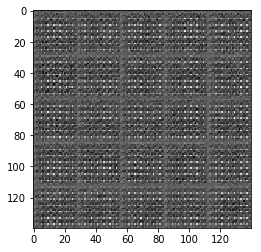

epoch : 1   Generator Loss : 2.1309 Discriminator Loss : 0.5645 
epoch : 1   Generator Loss : 0.7551 Discriminator Loss : 1.2570 
epoch : 1   Generator Loss : 1.7092 Discriminator Loss : 0.8482 
epoch : 1   Generator Loss : 2.2860 Discriminator Loss : 1.0641 
epoch : 2   Generator Loss : 1.1471 Discriminator Loss : 1.0136 


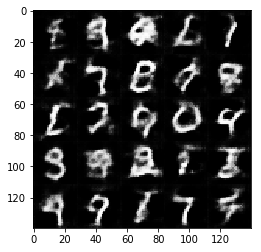

epoch : 2   Generator Loss : 1.3765 Discriminator Loss : 0.9777 
epoch : 2   Generator Loss : 1.2437 Discriminator Loss : 1.0175 
epoch : 2   Generator Loss : 1.4140 Discriminator Loss : 0.9549 
epoch : 2   Generator Loss : 1.7777 Discriminator Loss : 0.8644 


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Initial Generated Images


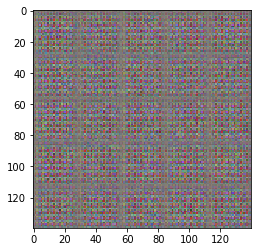

epoch : 1   Generator Loss : 5.8277 Discriminator Loss : 0.6545 
epoch : 1   Generator Loss : 5.4594 Discriminator Loss : 0.3676 
epoch : 1   Generator Loss : 0.7148 Discriminator Loss : 1.2202 
epoch : 1   Generator Loss : 6.9817 Discriminator Loss : 0.5609 
epoch : 1   Generator Loss : 2.0010 Discriminator Loss : 0.8324 


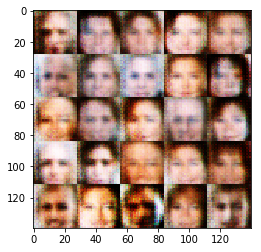

epoch : 1   Generator Loss : 0.2730 Discriminator Loss : 2.0439 
epoch : 1   Generator Loss : 0.7727 Discriminator Loss : 1.0611 
epoch : 1   Generator Loss : 1.0899 Discriminator Loss : 1.6239 
epoch : 1   Generator Loss : 1.8678 Discriminator Loss : 0.6450 
epoch : 1   Generator Loss : 1.1461 Discriminator Loss : 0.9751 


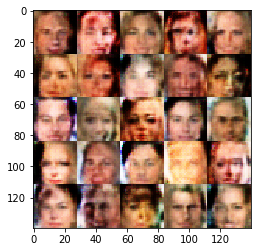

epoch : 1   Generator Loss : 1.5526 Discriminator Loss : 0.8961 
epoch : 1   Generator Loss : 0.6561 Discriminator Loss : 1.1843 
epoch : 1   Generator Loss : 1.8693 Discriminator Loss : 0.8111 
epoch : 1   Generator Loss : 1.4344 Discriminator Loss : 1.1041 
epoch : 1   Generator Loss : 1.8802 Discriminator Loss : 1.4074 


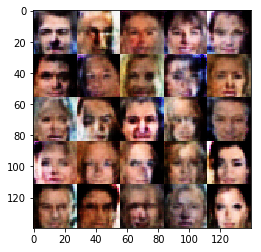

epoch : 2   Generator Loss : 2.4555 Discriminator Loss : 0.8698 
epoch : 2   Generator Loss : 1.4158 Discriminator Loss : 0.8002 
epoch : 2   Generator Loss : 0.9632 Discriminator Loss : 0.9456 
epoch : 2   Generator Loss : 2.1941 Discriminator Loss : 0.5780 
epoch : 2   Generator Loss : 2.0637 Discriminator Loss : 0.9862 


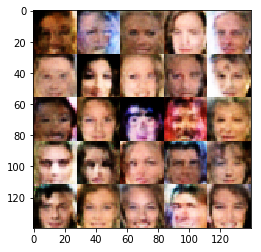

epoch : 2   Generator Loss : 0.5596 Discriminator Loss : 1.2953 
epoch : 2   Generator Loss : 1.3931 Discriminator Loss : 0.7736 
epoch : 2   Generator Loss : 0.6121 Discriminator Loss : 1.2124 
epoch : 2   Generator Loss : 2.8817 Discriminator Loss : 1.2886 
epoch : 2   Generator Loss : 1.2559 Discriminator Loss : 0.7487 


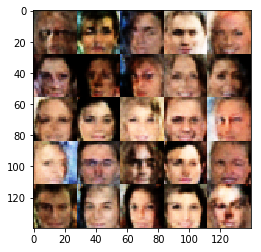

epoch : 2   Generator Loss : 2.0639 Discriminator Loss : 0.9971 
epoch : 2   Generator Loss : 1.5294 Discriminator Loss : 0.8552 
epoch : 2   Generator Loss : 0.5068 Discriminator Loss : 1.3979 
epoch : 2   Generator Loss : 0.6365 Discriminator Loss : 1.2187 
epoch : 2   Generator Loss : 1.7225 Discriminator Loss : 0.9321 


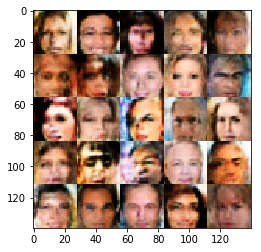

epoch : 2   Generator Loss : 2.1890 Discriminator Loss : 1.4913 
epoch : 3   Generator Loss : 1.3989 Discriminator Loss : 0.7009 
epoch : 3   Generator Loss : 3.2436 Discriminator Loss : 1.2133 
epoch : 3   Generator Loss : 1.0082 Discriminator Loss : 0.9355 
epoch : 3   Generator Loss : 0.7644 Discriminator Loss : 1.1401 


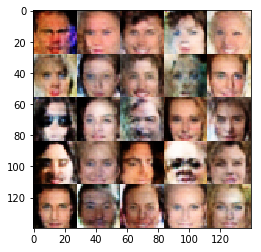

epoch : 3   Generator Loss : 1.8328 Discriminator Loss : 0.8089 
epoch : 3   Generator Loss : 3.1126 Discriminator Loss : 2.4479 
epoch : 3   Generator Loss : 1.1988 Discriminator Loss : 0.9676 
epoch : 3   Generator Loss : 0.6202 Discriminator Loss : 1.2421 
epoch : 3   Generator Loss : 0.9315 Discriminator Loss : 0.9795 


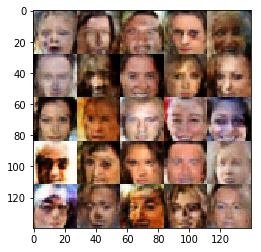

epoch : 3   Generator Loss : 0.7230 Discriminator Loss : 1.1369 
epoch : 3   Generator Loss : 1.5903 Discriminator Loss : 1.0029 
epoch : 3   Generator Loss : 2.9288 Discriminator Loss : 0.4114 
epoch : 3   Generator Loss : 2.3008 Discriminator Loss : 0.6632 
epoch : 3   Generator Loss : 2.2639 Discriminator Loss : 0.7473 


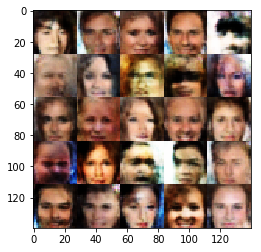

epoch : 3   Generator Loss : 1.7386 Discriminator Loss : 0.8798 
epoch : 3   Generator Loss : 1.1606 Discriminator Loss : 0.9708 


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)